# Week 5 - Testing Structured Data File Formats

The goal of this project is to evaluate tradeoffs between different file formats for structured data. In particular, we're going to evaluate size vs time to write rows into CSV, compressed CSV, and Parquet formats.

In [2]:
# pyarrow is the library that provides support for parquet files
# !pip install pyarrow

In [5]:
import sys
import os
import pyarrow
import pandas as pd
import numpy as np

In [11]:
# For my example, I'm going to generate some random data about locations on a theoretical map
# Don't try to make sense out of the topology or geography

def create_data(NUMROWS:int):
    raw = {
        'lat': np.random.randint(0,180000, NUMROWS)/1000,  # 0.000-180.000
        'lat_d': np.random.choice(['N','S'], NUMROWS),     # N or S
        'lng': np.random.randint(0,180000, NUMROWS)/1000,  # 0.000-180.000
        'lng_d': np.random.choice(['E','W'], NUMROWS),     # E or W
        'elevation': np.random.randint(0,10000, NUMROWS),  # 0-10km
        'climate': np.random.choice(['Tundra','Arid','Polar','Tropical','Alpine','Oceanic'], NUMROWS)
    }

    locations = pd.DataFrame(raw)
    return locations

In [15]:
# We also need a function that can run our whole exercise and return the file size and timing
# Returns (filesize, average_time)
def write_data(data:pd.DataFrame, format:str):
    if format == 'csv':
        writer = data.to_csv
        filename = 'tmp.csv'
    elif format == 'csv.gz':
        writer = data.to_csv
        filename = 'tmp.csv.gz'
    elif format == 'parquet':
        writer = data.to_parquet
        filename = 'tmp.parquet'
    else:
        return (-1, -1)
    
    tm = %timeit -q -n1 -r10 -o writer(filename)

    sz = os.stat(filename).st_size

    return (sz, tm.average)

In [55]:
# Here's our looped test
sizes = [1e2, 5e2, 1e3, 5e3, 1e4, 3e4, 5e4, 7e4, 1e5, 1e6, 1e7, 1e8]
formats = ['csv','csv.gz','parquet']
timings = []

for s in sizes:
    data = create_data(int(s))
    for f in formats:
        print(f'Writing {s} rows to {f}')
        (sz, tm) = write_data(data, f)
        timings.append((int(s), f, sz,tm))

Writing 100.0 rows to csv
Writing 100.0 rows to csv.gz
Writing 100.0 rows to parquet
Writing 500.0 rows to csv
Writing 500.0 rows to csv.gz
Writing 500.0 rows to parquet
Writing 1000.0 rows to csv
Writing 1000.0 rows to csv.gz
Writing 1000.0 rows to parquet
Writing 5000.0 rows to csv
Writing 5000.0 rows to csv.gz
Writing 5000.0 rows to parquet
Writing 10000.0 rows to csv
Writing 10000.0 rows to csv.gz
Writing 10000.0 rows to parquet
Writing 30000.0 rows to csv
Writing 30000.0 rows to csv.gz
Writing 30000.0 rows to parquet
Writing 50000.0 rows to csv
Writing 50000.0 rows to csv.gz
Writing 50000.0 rows to parquet
Writing 70000.0 rows to csv
Writing 70000.0 rows to csv.gz
Writing 70000.0 rows to parquet
Writing 100000.0 rows to csv
Writing 100000.0 rows to csv.gz
Writing 100000.0 rows to parquet
Writing 1000000.0 rows to csv
Writing 1000000.0 rows to csv.gz
Writing 1000000.0 rows to parquet
Writing 10000000.0 rows to csv
Writing 10000000.0 rows to csv.gz
Writing 10000000.0 rows to parquet

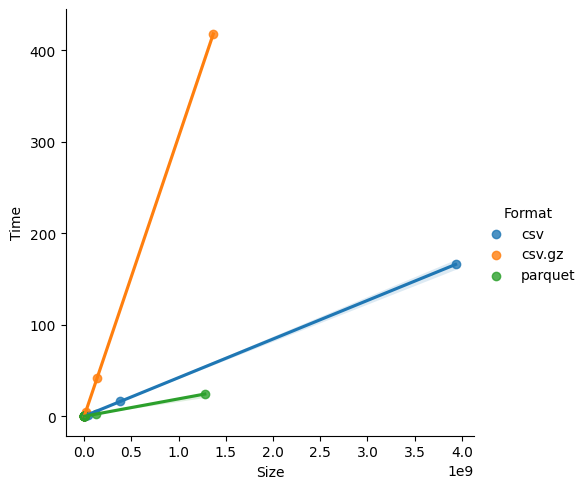

In [56]:
# Plot size and time by format to see which format gives us the best size/time tradeoffs
# We want something that doesn't go too far to the right (small) and stays low (fast) as the number of rows scales up

import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(timings, columns=['Rows','Format','Size','Time'])
sns.lmplot(df, x='Size', y='Time', hue='Format')

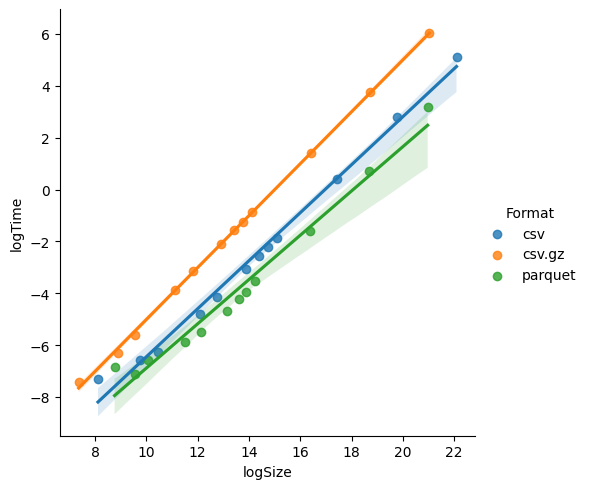

In [57]:
# Let's plot the log of Time and Size to scale the axes
df['logSize'] = df['Size'].apply(np.log)
df['logTime'] = df['Time'].apply(np.log)
sns.lmplot(df, x='logSize', y='logTime', hue='Format')